Initial Setup and Imports

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from datetime import datetime
import warnings
from scipy.stats import randint, uniform
from sklearn.pipeline import Pipeline
!pip install scipy
from scipy.stats import skew

warnings.filterwarnings('ignore')

In [4]:
# Load dataset

flightprice_df = pd.read_csv("/content/drive/MyDrive/Project_2024/DSP_Project/FlightFarePrediction_data.csv",nrows=1000000)
airports_df = pd.read_csv('/content/drive/MyDrive/Project_2024/DSP_Project/airports.csv')

Section A: Understanding the Data

In [5]:
# Display the first 5 rows of the DataFrame

flightprice_df.head(5)

,legId,searchDate,flightDate,startingAirport,destinationAirport,fareBasisCode,travelDuration,elapsedDays,isBasicEconomy,isRefundable,...,segmentsArrivalTimeEpochSeconds,segmentsArrivalTimeRaw,segmentsArrivalAirportCode,segmentsDepartureAirportCode,segmentsAirlineName,segmentsAirlineCode,segmentsEquipmentDescription,segmentsDurationInSeconds,segmentsDistance,segmentsCabinCode
0,65a8a691c4d77487a439d6f44c219a39,2022-04-17,2022-04-21,LGA,DFW,UA3NA0BQ,PT5H45M,0,True,False,...,1650551340||1650563100,2022-04-21T10:29:00.000-04:00||2022-04-21T12:4...,ATL||DFW,LGA||ATL,Delta||Delta,DL||DL,Airbus A321||Airbus A321,8940||8520,762||725,coach||coach
1,1ad3c9a84f803cc98028ba8c67f35941,2022-04-18,2022-04-24,ATL,LGA,H3AHZNN1,PT2H22M,0,False,False,...,1650853920,2022-04-24T22:32:00.000-04:00,LGA,ATL,American Airlines,AA,Embraer 170,8520,762,coach
2,510f3a1255b9843a8eae48032b191faf,2022-04-17,2022-04-22,OAK,LAX,YH0OASMR,PT7H11M,0,False,False,...,1650678600||1650697140,2022-04-22T18:50:00.000-07:00||2022-04-22T23:5...,SEA||ONT,OAK||SEA,Alaska Airlines||Alaska Airlines,AS||AS,Embraer 175||Airbus A320,7320||8940,672||956,coach||coach
3,ca0fb1ee992f752bbfdcd03a8b3e8ed0,2022-04-17,2022-05-18,LGA,SFO,MAUTA5MC,PT10H22M,0,False,False,...,1652914020||1652941920,2022-05-18T18:47:00.000-04:00||2022-05-18T23:3...,ATL||SFO,LGA||ATL,Delta||Delta,DL||DL,Airbus A321||Boeing 757-300,9420||18600,762||2135,coach||coach
4,5f7a29384cea410317ca308d2e065059,2022-04-17,2022-05-06,SFO,BOS,E0AJZNN1,PT8H29M,1,False,False,...,1651919400||1651929660,2022-05-07T06:30:00.000-04:00||2022-05-07T09:2...,JFK||BOS,SFO||JFK,JetBlue Airways||JetBlue Airways,B6||B6,Airbus A319-321||AIRBUS INDUSTRIE A321 SHARKLETS,20280||4560,2566||185,coach||coach


In [6]:
# Display a summary of the DataFrame, including the data types and non-null values
print("Summary of the DataFrame:\n")
flightprice_df.info()

Summary of the DataFrame:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 27 columns):
 #   Column                             Non-Null Count    Dtype  
---  ------                             --------------    -----  
 0   legId                              1000000 non-null  object 
 1   searchDate                         1000000 non-null  object 
 2   flightDate                         1000000 non-null  object 
 3   startingAirport                    1000000 non-null  object 
 4   destinationAirport                 1000000 non-null  object 
 5   fareBasisCode                      1000000 non-null  object 
 6   travelDuration                     1000000 non-null  object 
 7   elapsedDays                        1000000 non-null  int64  
 8   isBasicEconomy                     1000000 non-null  bool   
 9   isRefundable                       1000000 non-null  bool   
 10  isNonStop                          1000000 non-null  bool   
 11

In [7]:
# Display descriptive statistics to summarize the central tendency and dispersion of DataFrame's distribution
print("Descriptive statistics:\n")
flightprice_df.describe()

Descriptive statistics:



,elapsedDays,baseFare,totalFare,seatsRemaining,totalTravelDistance
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,920914.000000
mean,0.149023,332.699500,383.642963,5.619312,1564.817123
std,0.356142,198.576311,212.233363,2.965982,842.082246
min,0.000000,2.000000,23.970000,0.000000,97.000000
25%,0.000000,187.910000,228.600000,3.000000,862.000000
50%,0.000000,305.120000,351.600000,7.000000,1392.000000
75%,0.000000,444.650000,501.600000,8.000000,2376.000000
max,2.000000,7018.600000,7568.600000,10.000000,4430.000000


In [8]:
# Print the number of missing values in each column
print("Number of missing values in each column:\n")
flightprice_df.isnull().sum()

Number of missing values in each column:



,0
legId,0
searchDate,0
flightDate,0
startingAirport,0
destinationAirport,0
fareBasisCode,0
travelDuration,0
elapsedDays,0
isBasicEconomy,0
isRefundable,0


In [9]:
# Print the number of duplicate rows in the DataFrame
print("Number of duplicate rows in the DataFrame:\n")
flightprice_df.duplicated().sum()

Number of duplicate rows in the DataFrame:



23700

In [10]:
# Print the shape of the DataFrame (number of rows and columns)
print("Shape of the DataFrame (rows, columns):\n")
flightprice_df.shape

Shape of the DataFrame (rows, columns):



(1000000, 27)

Section B: Data Preprocessing

Initial Data Cleaning

In [11]:
# Extracting Relevant Columns into a New DataFrame

flightpredict_df = flightprice_df[['flightDate','segmentsAirlineName','segmentsArrivalTimeEpochSeconds', 'segmentsDepartureTimeEpochSeconds',
'startingAirport','destinationAirport','travelDuration','isBasicEconomy','isRefundable','isNonStop','totalFare','seatsRemaining','totalTravelDistance']]

# Remove duplicates
flightpredict_df = flightpredict_df.drop_duplicates()

# Handling missing values
# Fill missing values for numerical columns with the median
numerical_cols = flightpredict_df.select_dtypes(include=[np.number]).columns
flightpredict_df[numerical_cols] = flightpredict_df[numerical_cols].fillna(flightpredict_df[numerical_cols].median())

# Fill missing values for categorical columns with the mode
categorical_cols = flightpredict_df.select_dtypes(include=[object, 'category']).columns
flightpredict_df[categorical_cols] = flightpredict_df[categorical_cols].fillna(flightpredict_df[categorical_cols].mode().iloc[0])

flightpredict_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 916976 entries, 0 to 999999
Data columns (total 13 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   flightDate                         916976 non-null  object 
 1   segmentsAirlineName                916976 non-null  object 
 2   segmentsArrivalTimeEpochSeconds    916976 non-null  object 
 3   segmentsDepartureTimeEpochSeconds  916976 non-null  object 
 4   startingAirport                    916976 non-null  object 
 5   destinationAirport                 916976 non-null  object 
 6   travelDuration                     916976 non-null  object 
 7   isBasicEconomy                     916976 non-null  bool   
 8   isRefundable                       916976 non-null  bool   
 9   isNonStop                          916976 non-null  bool   
 10  totalFare                          916976 non-null  float64
 11  seatsRemaining                     916976 no

Data Transformations

In [12]:
#Convert 'flightDate' to datetime
flightpredict_df['flightDate'] = pd.to_datetime(flightpredict_df['flightDate'])

#Convert 'travelDuration' from ISO 8601 duration format to total minutes
flightpredict_df['travelDuration'] = flightpredict_df['travelDuration'].apply(lambda x: pd.Timedelta(x).total_seconds() / 60)

#Split 'segmentsAirlineName' to create a new column 'AirlineName' keeping only the first part of the segment
flightpredict_df['airlineName'] = flightpredict_df['segmentsAirlineName'].str.split('|', expand=True, n=1)[0]

#Extracting Number of stops
flightpredict_df['numberOfStops'] = flightpredict_df['segmentsAirlineName'].apply(lambda segments: len(segments.split('||')) - 1)

flightpredict_df.head()
#Converting Boolean to Int
for column in ['isBasicEconomy', 'isRefundable', 'isNonStop']:
    flightpredict_df[column] = flightpredict_df[column].astype(int)

#Formatting the Flight Date and extracting into multiple columns
flightpredict_df['flightMonth'] = flightpredict_df['flightDate'].dt.month
flightpredict_df['flightDay'] = flightpredict_df['flightDate'].dt.day
flightpredict_df['flightYear'] = flightpredict_df['flightDate'].dt.year

#Creating Distionary to extract the Airport Name and City Name from another dataframe

us_airports_df = airports_df[airports_df['COUNTRY'] == 'USA']
#Create the dictionary
airport_codes = us_airports_df.set_index('IATA')[['AIRPORT', 'CITY']].to_dict(orient='index')

#Standardize keys for clarity
airport_codes = {
    code: {'airport_name': details['AIRPORT'], 'city_name': details['CITY']}
    for code, details in airport_codes.items()
}

# Mapping Starting Airport Name and City from Dictionary
flightpredict_df['startingAirportName'] = flightpredict_df['startingAirport'].map(lambda x: airport_codes.get(x, {}).get('airport_name', 'Unknown'))
flightpredict_df['startingCityName'] = flightpredict_df['startingAirport'].map(lambda x: airport_codes.get(x, {}).get('city_name', 'Unknown'))

# Mapping Destination Airport Name and City from Dictionary
flightpredict_df['destinationAirportName'] = flightpredict_df['destinationAirport'].map(lambda x: airport_codes.get(x, {}).get('airport_name', 'Unknown'))
flightpredict_df['destinationCityName'] = flightpredict_df['destinationAirport'].map(lambda x: airport_codes.get(x, {}).get('city_name', 'Unknown'))

# Function to get the last segment from segmentsArrivalTimeEpochSeconds
def get_last_segment(arrival_time):
    return arrival_time.split("||")[-1]

# Function to get the first segment from segmentsDepartureTimeEpochSeconds
def get_first_segment(departure_time):
    return departure_time.split("||")[0]

# Create new columns with the last and first segments
flightpredict_df['lastSegmentArrival'] = flightpredict_df['segmentsArrivalTimeEpochSeconds'].apply(get_last_segment)
flightpredict_df['firstSegmentDeparture'] = flightpredict_df['segmentsDepartureTimeEpochSeconds'].apply(get_first_segment)

# Function to convert epoch time to datetime and extract date, month, year, hour, minute, second
def extract_datetime_components_vectorized(epoch_series):
    dt_series = pd.to_datetime(epoch_series, unit='s', utc=True)
    return pd.DataFrame({
        'Date': dt_series.dt.day,
        'Month': dt_series.dt.month,
        'Year': dt_series.dt.year,
        'Hour': dt_series.dt.hour,
        'Minute': dt_series.dt.minute,
        'Second': dt_series.dt.second
    })

# Apply the vectorized function to the 'lastSegmentArrival' column
arrival_components = extract_datetime_components_vectorized(flightpredict_df['lastSegmentArrival'].astype(int))
arrival_components.columns = ['arrival' + col for col in arrival_components.columns]

# Apply the vectorized function to the 'firstSegmentDeparture' column
departure_components = extract_datetime_components_vectorized(flightpredict_df['firstSegmentDeparture'].astype(int))
departure_components.columns = ['departure' + col for col in departure_components.columns]

# Concatenate the new columns to the original DataFrame
flightpredict_df = pd.concat([flightpredict_df, arrival_components, departure_components], axis=1)
flightpredict_df.head()

,flightDate,segmentsAirlineName,segmentsArrivalTimeEpochSeconds,segmentsDepartureTimeEpochSeconds,startingAirport,destinationAirport,travelDuration,isBasicEconomy,isRefundable,isNonStop,...,arrivalYear,arrivalHour,arrivalMinute,arrivalSecond,departureDate,departureMonth,departureYear,departureHour,departureMinute,departureSecond
0,2022-04-21,Delta||Delta,1650551340||1650563100,1650542400||1650554580,LGA,DFW,345.0,1,0,0,...,2022,17,45,0,21,4,2022,12,0,0
1,2022-04-24,American Airlines,1650853920,1650845400,ATL,LGA,142.0,0,0,1,...,2022,2,32,0,25,4,2022,0,10,0
2,2022-04-22,Alaska Airlines||Alaska Airlines,1650678600||1650697140,1650671280||1650688200,OAK,LAX,431.0,0,0,0,...,2022,6,59,0,22,4,2022,23,48,0
3,2022-05-18,Delta||Delta,1652914020||1652941920,1652904600||1652923320,LGA,SFO,622.0,0,0,0,...,2022,6,32,0,18,5,2022,20,10,0
4,2022-05-06,JetBlue Airways||JetBlue Airways,1651919400||1651929660,1651899120||1651925100,SFO,BOS,509.0,0,0,0,...,2022,13,21,0,7,5,2022,4,52,0


Section C: Exploratory Data Analysis (EDA)

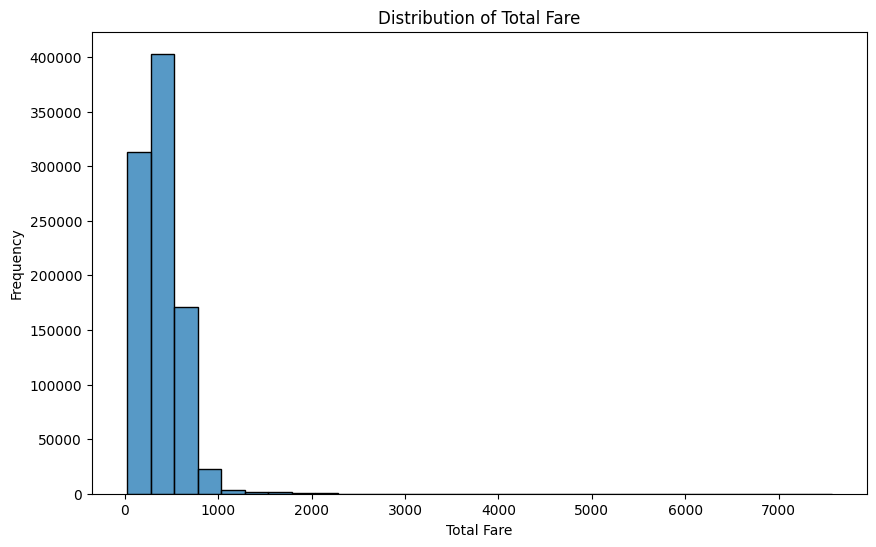

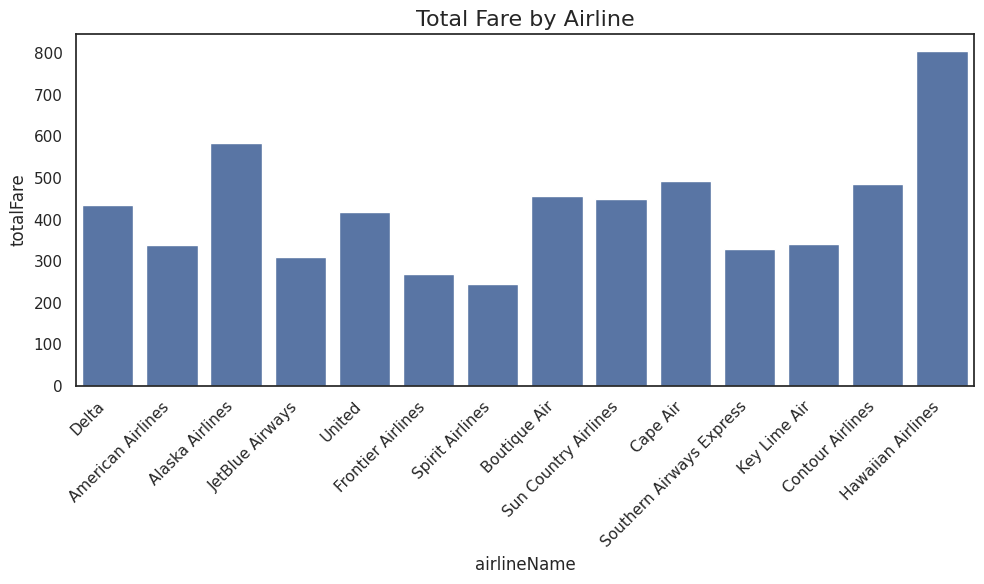

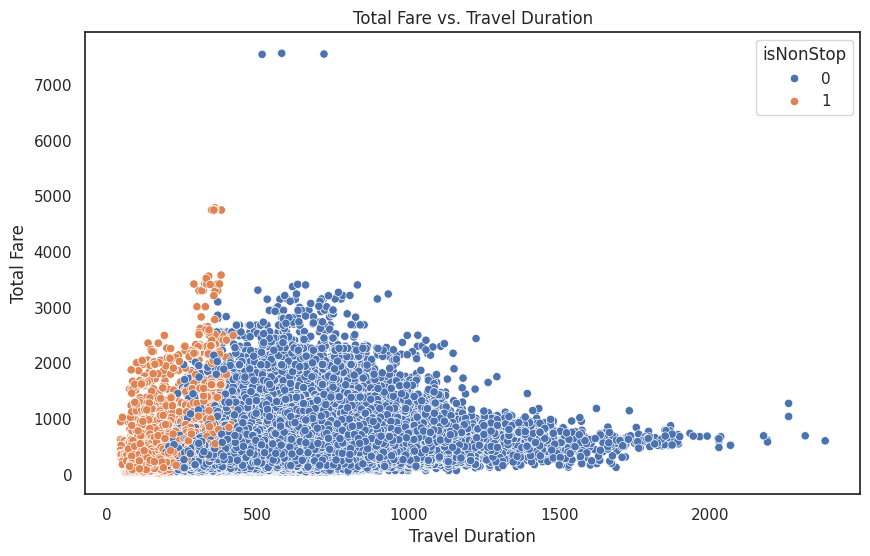

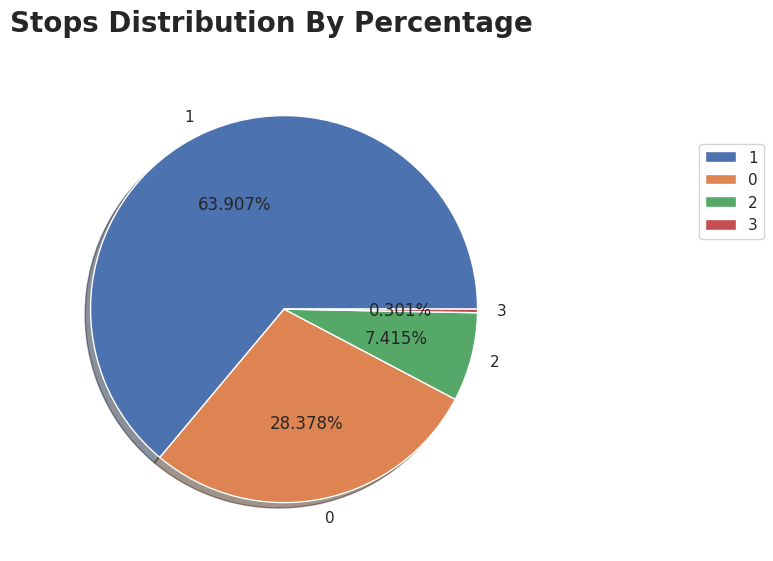

Text(0.5, 1.0, 'Distribution Of Flights By Destination City')

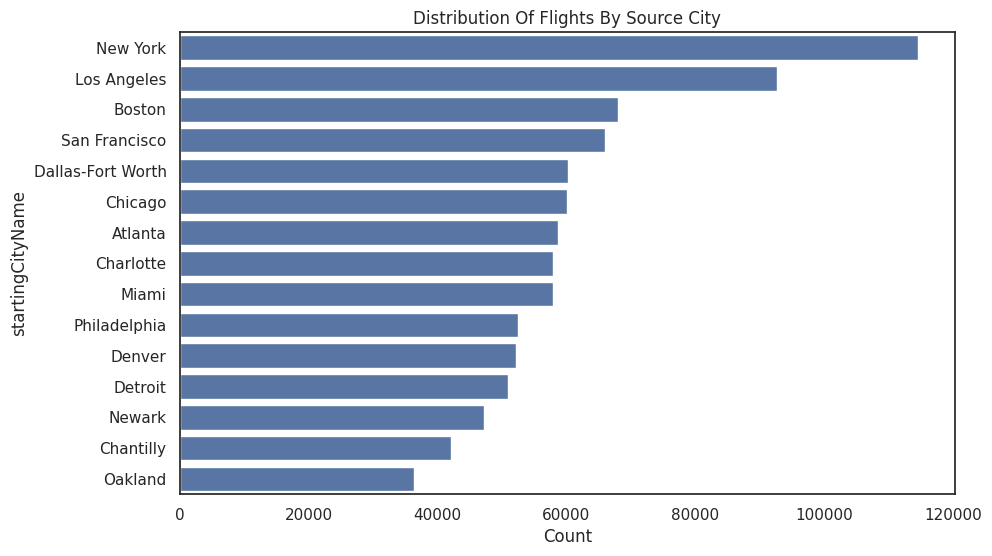

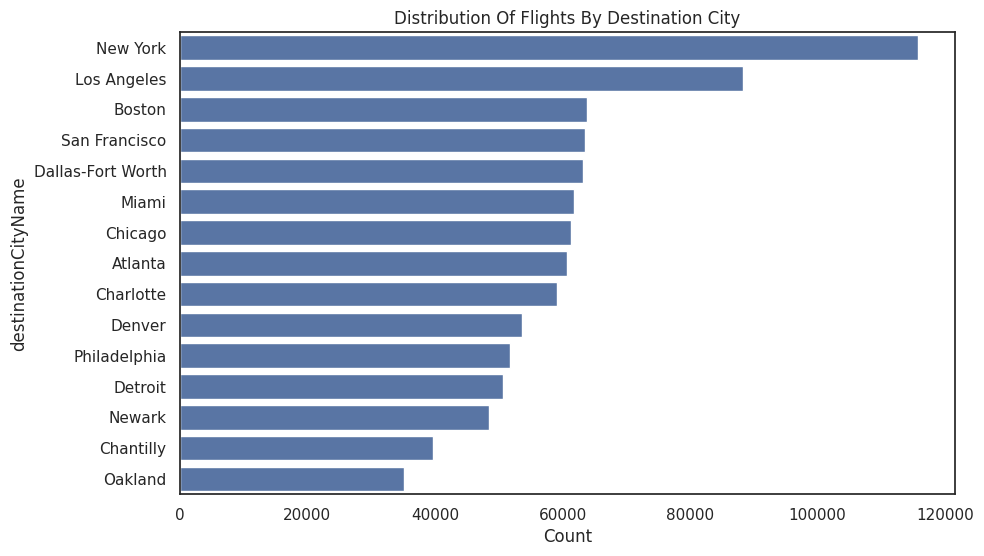

In [13]:
# Distribution of total fare
plt.figure(figsize=(10, 6))
sns.histplot(flightpredict_df['totalFare'], bins=30)
plt.title('Distribution of Total Fare')
plt.xlabel('Total Fare')
plt.ylabel('Frequency')
plt.show()

#Bar Chart for The Distribution of total fare by airline
sns.set(style="white")
plt.figure(figsize=(10, 6))
sns.barplot(data=flightpredict_df, x='airlineName', y='totalFare', ci=None)
plt.xticks(rotation=45, ha='right')
plt.title('Total Fare by Airline', fontsize=16)
plt.tight_layout()
plt.show()

# Scatter plot of total fare vs. travel duration
plt.figure(figsize=(10, 6))
sns.scatterplot(x='travelDuration', y='totalFare', hue='isNonStop', data=flightpredict_df)
plt.title('Total Fare vs. Travel Duration')
plt.xlabel('Travel Duration')
plt.ylabel('Total Fare')
plt.show()

#Pie Chart for Stops Analysis
fig, ax = plt.subplots(figsize=(8, 6))
fig.suptitle('Stops Distribution By Percentage', fontsize=20, fontweight='bold')
plt.tight_layout()
labels = flightpredict_df.numberOfStops.value_counts().index.tolist()
sizes = flightpredict_df.numberOfStops.value_counts().values.tolist()
ax.pie(sizes, autopct='%.3f%%', labels=labels, shadow=True, pctdistance=0.6, labeldistance=1.1)
ax.legend(bbox_to_anchor=(1.2, 1), loc=2, borderaxespad=5)
plt.show()

#Bar Graph for Source City by Frequency of Flights
source_count = flightpredict_df.startingCityName.value_counts().reset_index(name='Count')
plt.figure(figsize=(10,6))
sns.barplot(data=source_count,y='startingCityName',x='Count')
plt.title("Distribution Of Flights By Source City")

#Bar Graph for Destination City by Frequency of Flights
city_count = flightpredict_df.destinationCityName.value_counts().reset_index(name='Count')
plt.figure(figsize=(10,6))
sns.barplot(data=city_count,y='destinationCityName',x='Count')
plt.title("Distribution Of Flights By Destination City")

Distribution of Total Fare

The histogram shows that the total fare is positively skewed, indicating most fares are concentrated in the lower range with a few high-priced outliers. This skewness is expected as flight prices often have a few expensive options.

Total Fare by Airline

The bar chart reveals variations in average fares across different airlines, with some airlines consistently charging higher than others. This information can be useful for understanding price differences among carriers.

Total Fare vs. Travel Duration

The scatter plot shows a general trend of increasing fare with longer travel duration, but the relationship isn't perfectly linear. Non-stop flights tend to have higher fares for similar travel durations.

Stops Analysis

The pie chart clearly illustrates the distribution of flights based on the number of stops. Most flights have either 0 or 1 stop, while flights with more stops are less frequent. This insight can help understand the preference for direct or connecting routes.

Distribution of Flights by Source and Destination City

The bar chart reveals the distribution of flights based on source city and destination city, which can highlight the popular flight routes and city pairs.



Section D: Feature Engineering

In [14]:
# Dropping irrelevant columns for further analysis
flighttest_df = flightpredict_df.drop(['startingAirport', 'destinationAirport', 'firstSegmentDeparture', 'lastSegmentArrival', 'departureYear', 'arrivalYear', 'arrivalMonth', 'arrivalSecond', 'departureSecond', 'segmentsAirlineName', 'segmentsArrivalTimeEpochSeconds', 'segmentsDepartureTimeEpochSeconds'], axis=1)

# Function to classify the time of day based on hour
def classify_time(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

# Apply the classify_time function to create new columns for arrival and departure times of day
flighttest_df['arrives'] = flighttest_df['arrivalHour'].apply(classify_time)
flighttest_df['departs'] = flighttest_df['departureHour'].apply(classify_time)

# Function to classify the season based on month
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

# Apply the get_season function to create a new column for season
flighttest_df['season'] = flighttest_df['flightDate'].dt.month.apply(get_season)

# Combine airport name and city name into a single column for starting and destination airports
flighttest_df['startingAirportCityName'] = flighttest_df['startingAirportName'] + ' - ' + flighttest_df['startingCityName']
flighttest_df['destinationAirportCityName'] = flighttest_df['destinationAirportName'] + ' - ' + flighttest_df['destinationCityName']

# Convert data types to optimize memory usage
flighttest_df = flighttest_df.convert_dtypes()

# Select relevant columns for prediction
predict_df = flighttest_df[['totalFare', 'departureDate', 'departureMonth', 'departureHour', 'departureMinute', 'arrivalDate', 'arrivalHour', 'arrivalMinute', 'travelDuration', 'airlineName', 'startingAirportCityName', 'destinationAirportCityName', 'seatsRemaining', 'numberOfStops', 'totalTravelDistance', 'isBasicEconomy', 'isRefundable', 'arrives', 'departs', 'season']]

# List of columns to encode
columns_to_encode = ['airlineName', 'startingAirportCityName', 'destinationAirportCityName', 'arrives', 'departs', 'season']

# Loop through the columns and encode them using one-hot encoding
for column in columns_to_encode:
    # Encode the column
    encoded_data = pd.get_dummies(predict_df[column], prefix=column, dtype=int)
    # Concatenate the encoded data to the original DataFrame
    predict_df = pd.concat([predict_df, encoded_data], axis=1)
    # Drop the original column
    predict_df.drop(column, axis=1, inplace=True)


EDA After Feature Engineering

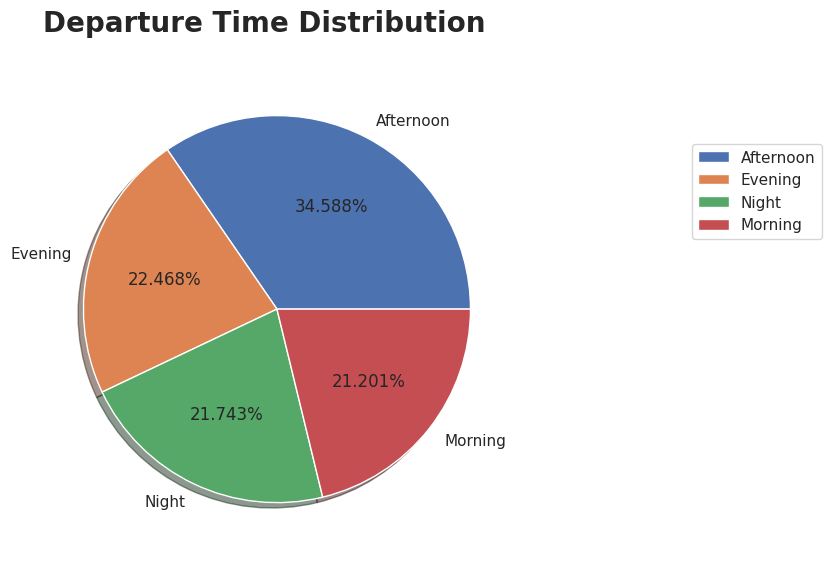

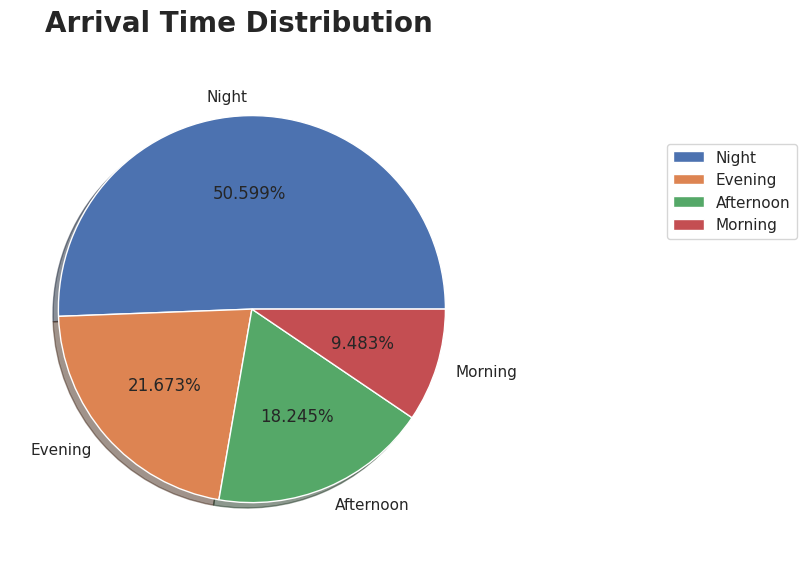

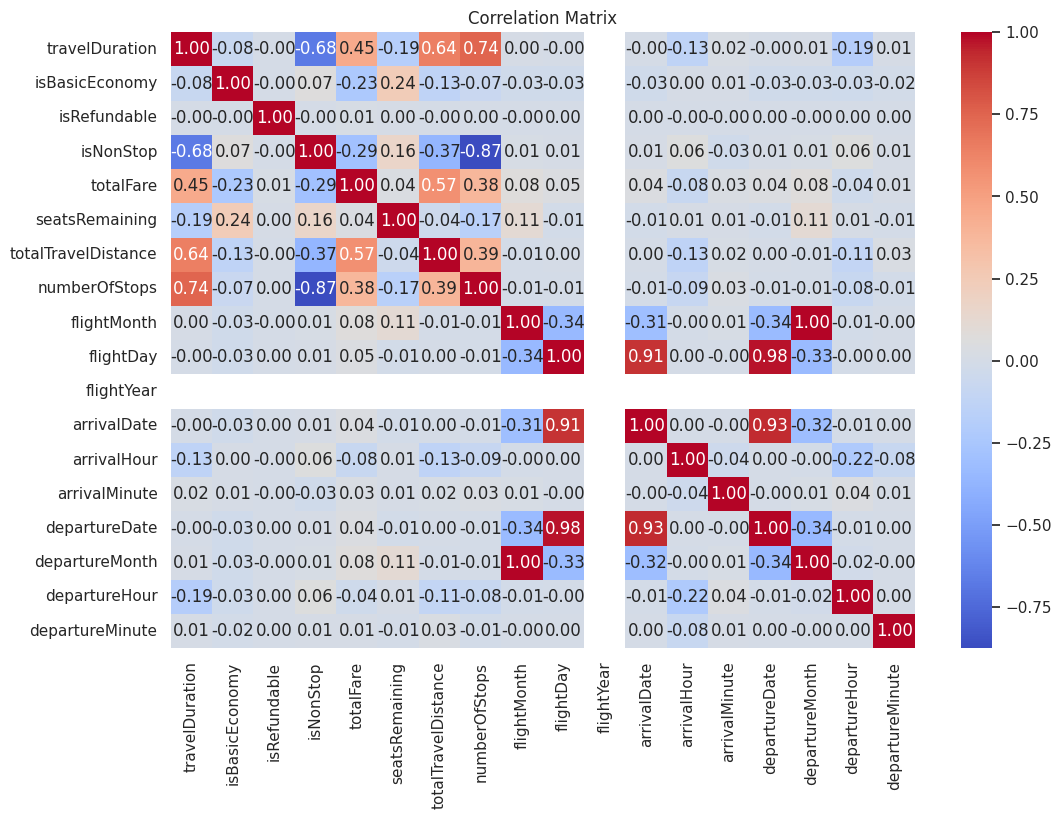

In [15]:
# Pie Chart for Departure Time Analysis
fig, ax = plt.subplots(figsize=(8, 6))
fig.suptitle('Departure Time Distribution', fontsize=20, fontweight='bold')
plt.tight_layout()
labels = flighttest_df.departs.value_counts().index.tolist()
sizes = flighttest_df.departs.value_counts().values.tolist()
ax.pie(sizes, autopct='%.3f%%', labels=labels, shadow=True, pctdistance=0.6, labeldistance=1.1)
ax.legend(bbox_to_anchor=(1.2, 1), loc=2, borderaxespad=5)
plt.show()

#Pie Chart for Arrival Time Analysis
fig, ax = plt.subplots(figsize=(8, 6))
fig.suptitle('Arrival Time Distribution', fontsize=20, fontweight='bold')
plt.tight_layout()
labels = flighttest_df.arrives.value_counts().index.tolist()
sizes = flighttest_df.arrives.value_counts().values.tolist()
ax.pie(sizes, autopct='%.3f%%', labels=labels, shadow=True, pctdistance=0.6, labeldistance=1.1)
ax.legend(bbox_to_anchor=(1.2, 1), loc=2, borderaxespad=5)
plt.show()

# Correlation matrix
plt.figure(figsize=(12, 8))
numerical_features = flighttest_df.select_dtypes(include=np.number)
sns.heatmap(numerical_features.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

Departure/Arrival Time Distribution

The pie charts summarize the distribution of flights across different times of the day for departure and arrival. This information can be used to understand common departure/arrival patterns and preferences for morning, afternoon, evening, or night flights.

Correlation Matrix

The heatmap depicts correlations between numerical features. Strong positive correlations are observed between features like total fare and travel distance or the number of stops, which is intuitive as longer trips or those with connections typically cost more.

Section E: Model Training and Evaluation

Random Forest Regressor with Best Identified Hyperparameters

In [16]:

# Using target variable for modeling
y = predict_df['totalFare']
X = predict_df.drop(['totalFare'], axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train the RandomForestRegressor model with optimized parameters
rf_reg = RandomForestRegressor(n_estimators=150, max_depth=15, min_samples_split=2, min_samples_leaf=1, n_jobs=-1, random_state=42)
rf_reg.fit(X_train_scaled, y_train)

# Make predictions on the test set using RandomForestRegressor
y_pred_rf = rf_reg.predict(X_test_scaled)

# Evaluate the model's performance
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Print the evaluation metrics
print(f"Mean Squared Error (MSE): {mse_rf}")
print(f"Root Mean Squared Error (RMSE): {rmse_rf}")
print(f"Mean Absolute Error (MAE): {mae_rf}")
print(f"R-squared (R2): {r2_rf}")

Mean Squared Error (MSE): 15020.31993580469
Root Mean Squared Error (RMSE): 122.55741485444562
Mean Absolute Error (MAE): 79.10084029072098
R-squared (R2): 0.662377299006667


The model shows a moderate level of performance with an RMSE of 122.56 and an MAE of 79.10, indicating average prediction errors. The R² value of 0.6624 suggests that the model explains about 66.24% of the variance in flight fares.

XGB with hyperparameter tuning

In [17]:

# Define the pipeline with scaling and the XGBoost model
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBRegressor(random_state=42))
])

# Hyperparameter tuning using RandomizedSearchCV for XGBoost within the pipeline
param_dist_xgb = {
    'xgb__n_estimators': randint(100, 150),
    'xgb__max_depth': randint(10, 15),
    'xgb__learning_rate': uniform(0.01, 0.05),
    'xgb__subsample': uniform(0.8, 0.2),
    'xgb__colsample_bytree': uniform(0.8, 0.2)
}

random_search_xgb = RandomizedSearchCV(estimator=pipeline, param_distributions=param_dist_xgb, n_iter=10, cv=2, n_jobs=-1, scoring='neg_mean_squared_error', random_state=42)

# Fit the model
random_search_xgb.fit(X_train, y_train)

# Best parameters from RandomizedSearchCV for XGBoost
best_params_xgb = random_search_xgb.best_params_
print(f"Best parameters for XGBoost: {best_params_xgb}")


Best parameters for XGBoost: {'xgb__colsample_bytree': 0.9202230023486418, 'xgb__learning_rate': 0.045403628889802275, 'xgb__max_depth': 14, 'xgb__n_estimators': 101, 'xgb__subsample': 0.944399754453365}


Training XGB with best parameters and performing cross validation

In [18]:
# Extract the best parameters
best_params_xgb = random_search_xgb.best_params_

# Update the pipeline with the best parameters
pipeline.set_params(**best_params_xgb)

# Fit the model with the best parameters on the entire training set
pipeline.fit(X_train, y_train)

# Predictions on the training set
y_train_pred = pipeline.predict(X_train)

# Predictions on the test set
y_test_pred = pipeline.predict(X_test)

In [20]:
# Evaluate the model on the training set
train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
train_r2 = r2_score(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)

print(f"Training RMSE: {train_rmse}")
print(f"Training R2: {train_r2}")
print(f"Training MAE: {train_mae}")

# Evaluate the model on the test set
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
test_r2 = r2_score(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

print(f"Test RMSE: {test_rmse}")
print(f"Test R2: {test_r2}")
print(f"Test MAE: {test_mae}")

# Perform cross-validation
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Convert negative MSE to positive RMSE
cv_rmse_scores = (-cv_scores)**0.5

print(f"Cross-validated RMSE scores: {cv_rmse_scores}")
print(f"Mean RMSE: {cv_rmse_scores.mean()}")
print(f"Standard Deviation of RMSE: {cv_rmse_scores.std()}")

Training RMSE: 89.65246149531275
Training R2: 0.8215020895004272
Training MAE: 58.37674990826672
Test RMSE: 105.92662849566479
Test R2: 0.7477896809577942
Test MAE: 65.15272798643416
Cross-validated RMSE scores: [109.08686255 108.80782741 107.86283961 110.57351496 106.79017026]
Mean RMSE: 108.62424295713322
Standard Deviation of RMSE: 1.26419454323642


The model shows good performance with a training RMSE of 89.65 and test RMSE of 105.93, indicating it generalizes well.

The R² scores (0.82 for training and 0.75 for test) suggest it explains a significant portion of the variance.

Cross-validation confirms stability with a mean RMSE of 108.62 and low standard deviation.

Section F: Model Improvement

Checking skewness of target variable 'totalFare'

In [26]:
target = predict_df['totalFare']
skewness = skew(target)
print(f'Skewness: {skewness}')

Skewness: 2.249598535958815


The skewness value of 2.25 indicates that totalFare data is positively skewed, i.e., distribution has a longer tail on the right side, with a few high values pulling the mean to the right.

Identifying outliers

In [27]:
Q1 = predict_df['totalFare'].quantile(0.25)
Q3 = predict_df['totalFare'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = predict_df[(predict_df['totalFare'] < lower_bound) | (predict_df['totalFare'] > upper_bound)]

outlier_summary = outliers['totalFare'].describe()
print(outlier_summary)

count        12456.0
mean     1274.467175
std       442.205668
min           911.61
25%           986.61
50%         1088.155
75%        1442.6225
max           7568.6
Name: totalFare, dtype: Float64


The maximum value (7,568.60) seems significantly higher than the 75th percentile (1,442.62), indicating potential outliers.

Handling Outliers by Capping

In [28]:
cap_value = upper_bound
predict_df['totalFare'] = predict_df['totalFare'].clip(upper=cap_value)

# Recheck the distribution after capping
new_skewness = skew(predict_df['totalFare'])
print(f'New Skewness: {new_skewness}')

New Skewness: 0.6232490633076826


The new skewness value of 0.62 indicates that totalFare data is now much closer to a normal distribution.

Retraining XGB model and cross-training after handling outliers

In [38]:
# Splitting the data into training and testing sets
X = predict_df.drop(columns=['totalFare'])
y = predict_df['totalFare']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Setting up the pipeline with StandardScaler and XGBoost model
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', xgb.XGBRegressor(**best_params_xgb, random_state=42))
])

# Performing cross-validation
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Training the model
pipeline.fit(X_train, y_train)

# Making predictions
predictions = pipeline.predict(X_test)

# Calculating evaluation metrics
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

# Printing evaluation metrics
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2): {r2}")

# Printing cross-validation scores
print(f"Cross-Validation MSE Scores: {-cv_scores}")
print(f"Mean Cross-Validation MSE: {-cv_scores.mean()}")

Mean Squared Error (MSE): 8307.8811752158
Mean Absolute Error (MAE): 67.37135226254675
R-squared (R2): 0.7634745836257935
Cross-Validation MSE Scores: [8384.87754826 8395.56438929 8414.1266454  8415.16895554 8321.85185076]
Mean Cross-Validation MSE: 8386.317877851583


The model shows strong performance with an R-squared of 0.76, indicating it explains about 76% of the variance in flight delays. The MSE and MAE suggest reasonable prediction power of the model. The consistent cross-validation MSE scores highlight the model’s reliability.

Impact of Outlier Handling:

The RMSE improved significantly after handling outliers, dropping from 105.93 to 91.58. This indicates that the model’s predictions are closer to the actual values when outliers are managed.

The R2 score improved slightly from 0.75 to 0.76, suggesting a marginally better fit of the model to the data.

Handling outliers has generally improved the model’s performance, especially in terms of RMSE and R2. The slight increase in MAE could be due to the model becoming more sensitive to smaller errors after outliers are removed.

Overall, Model 2 (after outlier handling) seems to be more robust and accurate.

Section G: Performance Analysis

In [31]:
# Check if predicted range falls within actual range

actual_min = y_test.min()
actual_max = y_test.max()
predicted_min = predictions.min()
predicted_max = predictions.max()

print(f"Actual range: {actual_min} to {actual_max}")
print(f"Predicted range: {predicted_min} to {predicted_max}")

# Checking if the predicted range covers the actual range
if predicted_min <= actual_min and predicted_max >= actual_max:
    print("The predicted range covers the actual range of values.")
else:
    print("The predicted range does NOT cover the actual range of values.")

Actual range: 23.97 to 911.6
Predicted range: -0.45984745025634766 to 981.8260498046875
The predicted range covers the actual range of values.


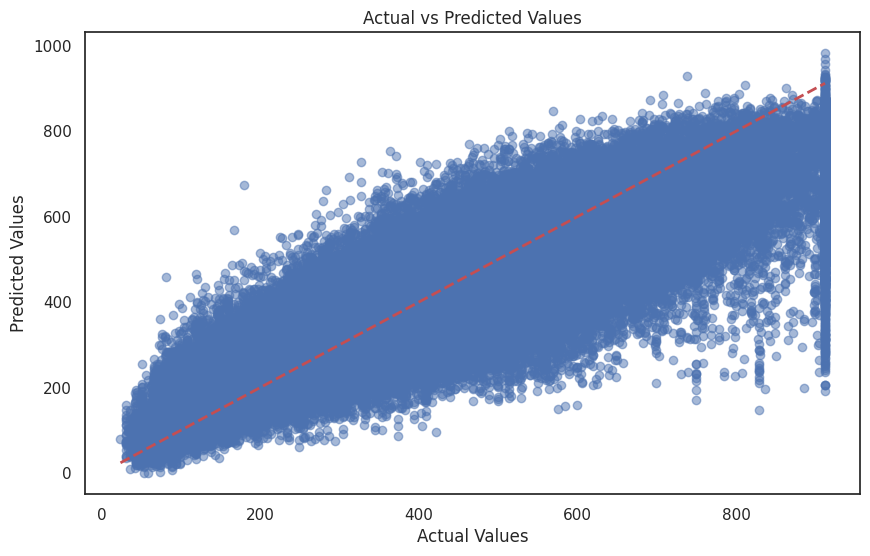

In [37]:
# Plotting actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()

In [32]:
# Residuals Analysis

residuals = y_test - predictions

# Summary statistics of residuals
residuals_summary = pd.DataFrame(residuals).describe()
print(residuals_summary)

# Mean of residuals
mean_residual = np.mean(residuals)
print(f"Mean of Residuals: {mean_residual}")

# Standard deviation of residuals
std_residual = np.std(residuals)
print(f"Standard Deviation of Residuals: {std_residual}")

# Mean Squared Error of residuals
mse_residual = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error (MSE) of Residuals: {mse_residual}")

# Mean Absolute Error of residuals
mae_residual = mean_absolute_error(y_test, predictions)
print(f"Mean Absolute Error (MAE) of Residuals: {mae_residual}")

# R-squared of residuals
r2_residual = r2_score(y_test, predictions)
print(f"R-squared (R2) of Residuals: {r2_residual}")

        totalFare
count    183396.0
mean     0.117117
std     91.147752
min   -494.110022
25%    -57.148734
50%     -9.484503
75%     45.107986
max    718.979395
Mean of Residuals: 0.11711732139541572
Standard Deviation of Residuals: 91.14750385363732
Mean Squared Error (MSE) of Residuals: 8307.8811752158
Mean Absolute Error (MAE) of Residuals: 67.37135226254675
R-squared (R2) of Residuals: 0.7634745836257935


The mean of residuals is close to zero (0.117), indicating that the model’s predictions are unbiased on average.

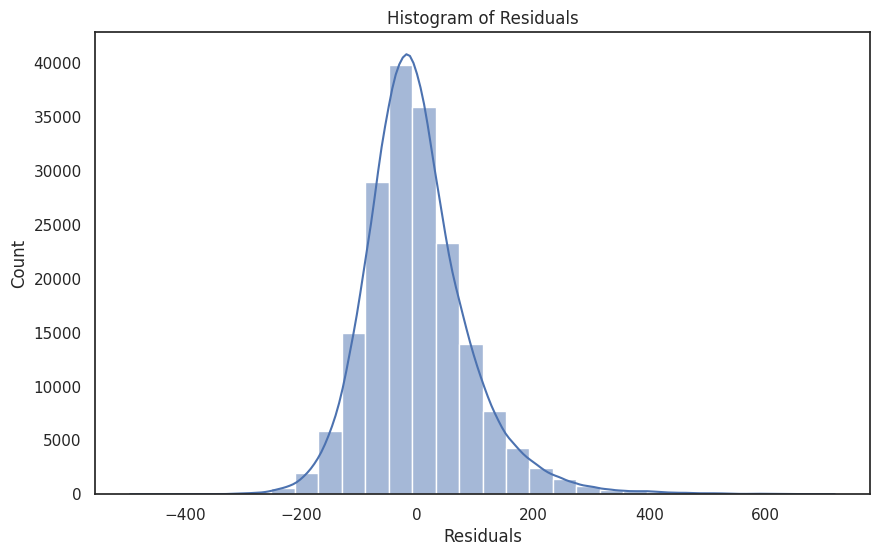

In [34]:
residuals = y_test - predictions

# Histogram of Residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.xlabel('Residuals')
plt.title('Histogram of Residuals')
plt.show()